
# Quantile Regression

    .. versionadded:: 2.0.0

The script is inspired by this awesome example in sklearn:  
https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html

!!! The feature is only supported using the Python, R, and C packages.   
!!! In addition, quantile crossing can happen due to limitation in the algorithm.


In [4]:
import numpy as np
import xgboost as xgb

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Dict

In [5]:
def f(x: np.ndarray) -> np.ndarray:
    """The function to predict."""
    return x * np.sin(x)

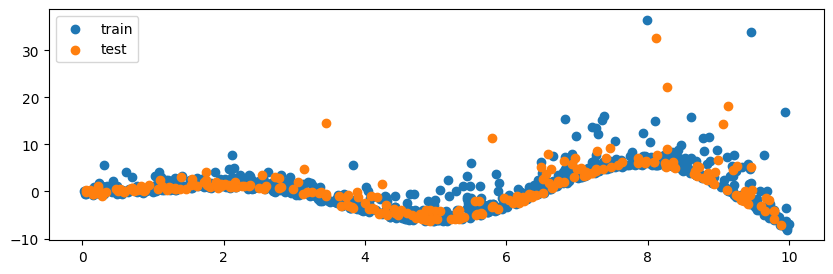

In [13]:
rng = np.random.RandomState(1994)
# Generate a synthetic dataset for demo, the generate process is from the sklearn example.
X = np.atleast_2d(rng.uniform(0, 10.0, size=1000)).T
expected_y = f(X).ravel()

sigma = 0.5 + X.ravel() / 10.0
noise = rng.lognormal(sigma=sigma) - np.exp(sigma**2.0 / 2.0)
y = expected_y + noise

# Train on 0.05 and 0.95 quantiles. The model is similar to multi-class and multi-target models.
alpha = np.array([0.05, 0.5, 0.95])
evals_result: Dict[str, Dict] = {}

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)

plt.figure(figsize=(10,3))
plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.legend()
plt.show()

In [8]:
# We will be using the `hist` tree method, quantile DMatrix can be used to preserve memory.
# Do not use the `exact` tree method for quantile regression, otherwise the performance might drop.
Xy = xgb.QuantileDMatrix(X, y)

# use Xy as a reference
Xy_test = xgb.QuantileDMatrix(X_test, y_test, ref=Xy)

booster = xgb.train(
    {
        # Use the quantile objective function.
        "objective": "reg:quantileerror",
        "tree_method": "hist",
        "quantile_alpha": alpha,
        # Let's try not to overfit.
        "learning_rate": 0.04,
        "max_depth": 5,
    },
    Xy,
    num_boost_round=32,
    early_stopping_rounds=2,
    # The evaluation result is a weighted average across multiple quantiles.
    evals=[(Xy, "Train"), (Xy_test, "Test")],
    evals_result=evals_result,
)

xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
scores = booster.inplace_predict(xx)

# dim 1 is the quantiles
assert scores.shape[0] == xx.shape[0]
assert scores.shape[1] == alpha.shape[0]

y_lower = scores[:, 0]  # alpha=0.05
y_med = scores[:, 1]  # alpha=0.5, median
y_upper = scores[:, 2]  # alpha=0.95

# Train a mse model for comparison
booster = xgb.train(
    {
        "objective": "reg:squarederror",
        "tree_method": "hist",
        # Let's try not to overfit.
        "learning_rate": 0.04,
        "max_depth": 5,
    },
    Xy,
    num_boost_round=32,
    early_stopping_rounds=2,
    evals=[(Xy, "Train"), (Xy_test, "Test")],
    evals_result=evals_result,
)
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
y_pred = booster.inplace_predict(xx)



[0]	Train-quantile:1.69179	Test-quantile:1.44578
[1]	Train-quantile:1.59699	Test-quantile:1.35754
[2]	Train-quantile:1.50794	Test-quantile:1.27359
[3]	Train-quantile:1.42710	Test-quantile:1.19805
[4]	Train-quantile:1.35018	Test-quantile:1.12589
[5]	Train-quantile:1.27942	Test-quantile:1.05916
[6]	Train-quantile:1.21302	Test-quantile:0.99379
[7]	Train-quantile:1.15200	Test-quantile:0.93655
[8]	Train-quantile:1.09624	Test-quantile:0.88742
[9]	Train-quantile:1.04371	Test-quantile:0.84360
[10]	Train-quantile:0.99875	Test-quantile:0.80729
[11]	Train-quantile:0.95143	Test-quantile:0.76757
[12]	Train-quantile:0.90939	Test-quantile:0.73699
[13]	Train-quantile:0.87741	Test-quantile:0.71054
[14]	Train-quantile:0.84838	Test-quantile:0.68628
[15]	Train-quantile:0.82167	Test-quantile:0.66649
[16]	Train-quantile:0.79718	Test-quantile:0.64818
[17]	Train-quantile:0.77258	Test-quantile:0.62863
[18]	Train-quantile:0.75094	Test-quantile:0.61003
[19]	Train-quantile:0.72947	Test-quantile:0.59220
[20]	Train

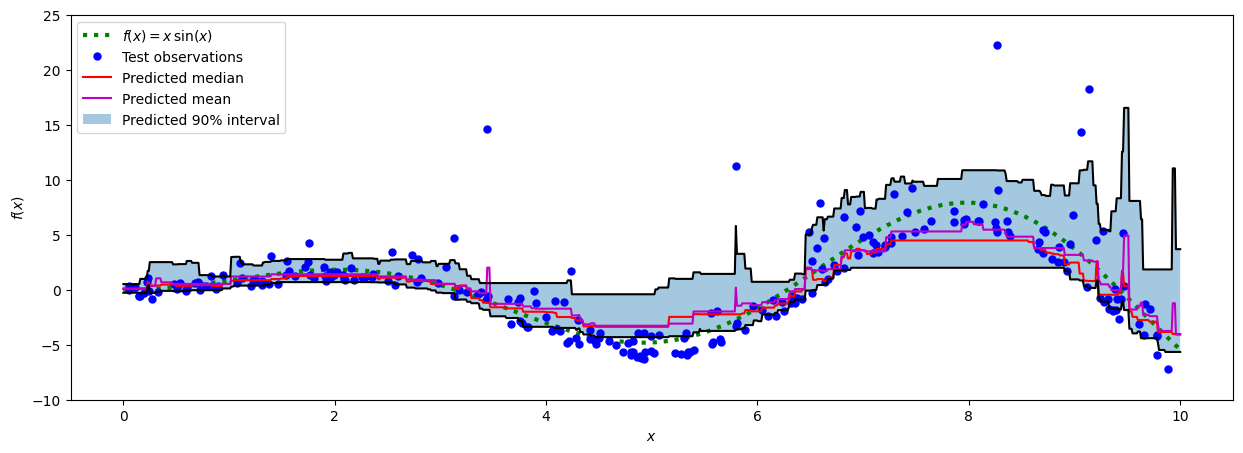

In [12]:
fig = plt.figure(figsize=(15, 5))

plt.plot(xx, f(xx), "g:", linewidth=3, label=r"$f(x) = x\,\sin(x)$")
plt.plot(X_test, y_test, "b.", markersize=10, label="Test observations")
plt.plot(xx, y_med, "r-", label="Predicted median")
plt.plot(xx, y_pred, "m-", label="Predicted mean")
plt.plot(xx, y_upper, "k-")
plt.plot(xx, y_lower, "k-")
plt.fill_between(xx.ravel(), y_lower, y_upper, alpha=0.4, label="Predicted 90% interval")

plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.ylim(-10, 25)
plt.legend(loc="upper left")
plt.show()